<a href="https://colab.research.google.com/github/Karalius/Calculator/blob/master/334.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module 3: Machine Learning

## Sprint 3: Introduction to Natural Language Processing and Computer Vision

## Subproject 4: Other Machine Learning topics

This notebook will be about more practical machine learning matters, such as:

- Data leakage - are my features not contaminated with information that will not be available during the production phase?
- Problem framing - is machine learning the right tool for this problem? If so, how to design the overall solution?
- Machine learning model testing and debugging - how can I be sure that the model will not crash and the predictions will be as expected?

## Learning outcomes

- Data leakage
- Machine learning problem framing
- Machine learning model testing
- Machine learning model debugging

---

## Data leakage

One concept that commonly ruins machine learning pipelines is data leakage - having features during the development phase that will not be available during the production phase. The concept might sound subtle, so let's learn it in more detail using the tutorial below:

- https://www.kaggle.com/alexisbcook/data-leakage

To strenghten our understanding about this important concept further, let's look at a practical example.

## Data leakage in practice

Let's first import the packages - our setup will be similar to the NLP notebook we had earlier.

In [ ]:
!pip install scikit-learn --upgrade

In [ ]:
import numpy as np
import pandas as pd
from sklearn import datasets, metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
import re

from sklearn import set_config
set_config(display='diagram')

RANDOM_STATE = 7

We will be using the newsgroups dataset, the same 4 categories we used before: 

In [ ]:
categories = ['comp.sys.mac.hardware', 'comp.windows.x', 'sci.med', 'sci.space']

x_train = datasets.fetch_20newsgroups(subset='train', categories=categories)
x_val = datasets.fetch_20newsgroups(subset='test', categories=categories)

target_id_to_name = {idx: x_val.target_names[idx] for idx in range(len(categories))}

train_df = pd.DataFrame({'text': x_train.data, 'target': x_train.target})
val_df = pd.DataFrame({'text': x_val.data, 'target': x_val.target})

train_df['target'] = train_df['target'].map(target_id_to_name)
val_df['target'] = val_df['target'].map(target_id_to_name)

train_df.head()

,text,target
0,From: jbh55289@uxa.cso.uiuc.edu (Josh Hopkins)...,sci.space
1,From: nodine@lcs.mit.edu (Mark H. Nodine)\nSub...,comp.sys.mac.hardware
2,From: drisko@ics.com (Jason Drisko)\nSubject: ...,comp.windows.x
3,From: straw@cam.nist.gov (Mike_Strawbridge_x38...,comp.windows.x
4,From: petrack@vnet.IBM.COM\nSubject: disabling...,comp.sys.mac.hardware


As we have the training data ready, we can train the pipeline:

In [ ]:
cv = CountVectorizer(
    lowercase=True,
    max_features=15000,
    min_df=50,
    binary=True,
    ngram_range=(1,2),
    strip_accents='ascii'
)

feature_selector = SelectFromModel(
    LogisticRegression(max_iter=1000),
    threshold=0.05
)

model = LogisticRegression(max_iter=1000)

pipe = Pipeline(
    steps=[
        ('preprocessor', cv),
        ('feature_selector', feature_selector),
        ('model',  model)]
)

pipe.fit(train_df['text'], train_df['target'])

Pipeline(steps=[('preprocessor',
                 CountVectorizer(binary=True, max_features=15000, min_df=50,
                                 ngram_range=(1, 2), strip_accents='ascii')),
                ('feature_selector',
                 SelectFromModel(estimator=LogisticRegression(max_iter=1000),
                                 threshold=0.05)),
                ('model', LogisticRegression(max_iter=1000))])

Now let's look at the classification report to inspect the performance on the validation set:

In [ ]:
val_df['target_prediction'] = pipe.predict(val_df['text'])
print(metrics.classification_report(val_df['target'], val_df['target_prediction']))

                       precision    recall  f1-score   support

comp.sys.mac.hardware       0.82      0.89      0.86       385
       comp.windows.x       0.87      0.86      0.87       395
              sci.med       0.84      0.80      0.82       396
            sci.space       0.88      0.87      0.88       394

             accuracy                           0.86      1570
            macro avg       0.86      0.86      0.86      1570
         weighted avg       0.86      0.86      0.86      1570



To inspect the performance on the validation set even further, let's plot the confusion matrix:

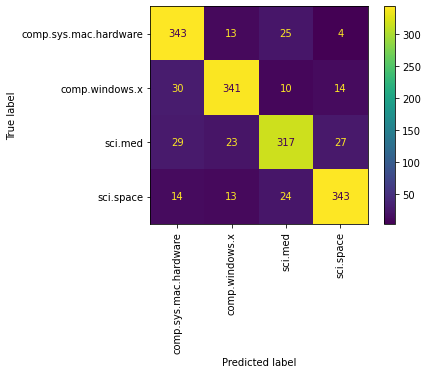

In [ ]:
metrics.plot_confusion_matrix(
    pipe,
    val_df['text'],
    val_df['target'],
    xticks_rotation='vertical'
)

There seem to be no mistakes that are much more common than others, but the most common mistake is predicting comp.sys.mac.hardware, when the true label is comp.windows.x.

Now let's create a new input text, one that has data leakage - the target text appended at the end:

In [ ]:
train_df['text_leaked'] = train_df['text'] + train_df['target']
val_df['text_leaked'] = val_df['text'] + val_df['target']
train_df['text_leaked'].iloc[0]

'From: jbh55289@uxa.cso.uiuc.edu (Josh Hopkins)\nSubject: Re: Griffin / Office of Exploration: RIP\nArticle-I.D.: news.C51r3o.9wK\nOrganization: University of Illinois at Urbana\nLines: 23\n\nyamauchi@ces.cwru.edu (Brian Yamauchi) writes:\n\n>Any comments on the absorbtion of the Office of Exploration into the\n>Office of Space Sciences and the reassignment of Griffin to the "Chief\n>Engineer" position?  Is this just a meaningless administrative\n>shuffle, or does this bode ill for SEI?\n\nUnfortunately, things have been boding ill (is that a legitimate conjugation?)\nfor a while.  While the Office of Exploration had some great ideas, they never\ngot much money.  I\'ve heard good things about Griffin, but it\'s hard to want\nhim back in a job where he couldn\'t do anything.\n\n>Does anyone know what his new duties will be?\n\nThe group examining the Freedom-based space station redesign proposals is \nheaded by Michael Griffin, "NASA\'s cheif engineer" in the words of Space News.\nI bel

With all of the text that is already there, it would be easy to miss the leaked target even in the very end of the text, but what if we had put it somewhere in the middle of the text? Leaked features can hide among the normal features.

Let's train on the leaked variant of the input, but validate on the non-leaked variant:

In [ ]:
pipe.fit(train_df['text_leaked'], train_df['target'])

val_df['target_prediction'] = pipe.predict(val_df['text'])
print(metrics.classification_report(val_df['target'], val_df['target_prediction']))

                       precision    recall  f1-score   support

comp.sys.mac.hardware       0.99      0.25      0.40       385
       comp.windows.x       0.64      0.94      0.76       395
              sci.med       0.73      0.74      0.74       396
            sci.space       0.73      0.91      0.81       394

             accuracy                           0.71      1570
            macro avg       0.77      0.71      0.68      1570
         weighted avg       0.77      0.71      0.68      1570



We see a large drop in accuracy, however, the model still performs reasonably well. In some sense it would be better if the accuracy would drop a lot, as this would at least make it easier to see that something is wrong in our setup.

What if the validate on the leaked version of the input?

In [ ]:
val_df['target_prediction'] = pipe.predict(val_df['text_leaked'])
print(metrics.classification_report(val_df['target'], val_df['target_prediction']))

                       precision    recall  f1-score   support

comp.sys.mac.hardware       1.00      1.00      1.00       385
       comp.windows.x       1.00      1.00      1.00       395
              sci.med       1.00      1.00      1.00       396
            sci.space       1.00      1.00      1.00       394

             accuracy                           1.00      1570
            macro avg       1.00      1.00      1.00      1570
         weighted avg       1.00      1.00      1.00      1570



We get perfect validation scores, which in most cases is impossible to achieve without leakage. You should always be cautious when you see results that are too good to be true.

While adding the target to our input made the leakage quite obvious based on the performance on the validation set, things could be a bit more subtle if we had a soft leakage when only a part of the target would be available in the input text.

Let's add the first 4 letters of the target to our input:

In [ ]:
train_df['text_leaked_soft'] = train_df['text'] + train_df['target'].apply(lambda x: x[:4])
val_df['text_leaked_soft'] = val_df['text'] + val_df['target'].apply(lambda x: x[:4])
train_df['text_leaked_soft'].iloc[0]

'From: jbh55289@uxa.cso.uiuc.edu (Josh Hopkins)\nSubject: Re: Griffin / Office of Exploration: RIP\nArticle-I.D.: news.C51r3o.9wK\nOrganization: University of Illinois at Urbana\nLines: 23\n\nyamauchi@ces.cwru.edu (Brian Yamauchi) writes:\n\n>Any comments on the absorbtion of the Office of Exploration into the\n>Office of Space Sciences and the reassignment of Griffin to the "Chief\n>Engineer" position?  Is this just a meaningless administrative\n>shuffle, or does this bode ill for SEI?\n\nUnfortunately, things have been boding ill (is that a legitimate conjugation?)\nfor a while.  While the Office of Exploration had some great ideas, they never\ngot much money.  I\'ve heard good things about Griffin, but it\'s hard to want\nhim back in a job where he couldn\'t do anything.\n\n>Does anyone know what his new duties will be?\n\nThe group examining the Freedom-based space station redesign proposals is \nheaded by Michael Griffin, "NASA\'s cheif engineer" in the words of Space News.\nI bel

That sci. at the very end is our partial target leakage.

Let's train on the input with partial leakage and validate on the input without leakage:

In [ ]:
pipe.fit(train_df['text_leaked_soft'], train_df['target'])

val_df['target_prediction'] = pipe.predict(val_df['text'])
print(metrics.classification_report(val_df['target'], val_df['target_prediction']))

                       precision    recall  f1-score   support

comp.sys.mac.hardware       0.82      0.88      0.84       385
       comp.windows.x       0.87      0.86      0.87       395
              sci.med       0.83      0.79      0.81       396
            sci.space       0.88      0.88      0.88       394

             accuracy                           0.85      1570
            macro avg       0.85      0.85      0.85      1570
         weighted avg       0.85      0.85      0.85      1570



The performance is only slightly worse than when training on the original input (without no leakage).

How about validating on the input with partial leakage?

In [ ]:
val_df['target_prediction'] = pipe.predict(val_df['text_leaked_soft'])
print(metrics.classification_report(val_df['target'], val_df['target_prediction']))

                       precision    recall  f1-score   support

comp.sys.mac.hardware       0.89      0.96      0.92       385
       comp.windows.x       0.96      0.88      0.92       395
              sci.med       0.93      0.92      0.92       396
            sci.space       0.92      0.92      0.92       394

             accuracy                           0.92      1570
            macro avg       0.92      0.92      0.92      1570
         weighted avg       0.92      0.92      0.92      1570



Now the score is not obviously too good, detecting such cases is more difficult. Looking at the confusion matrix might help us though:

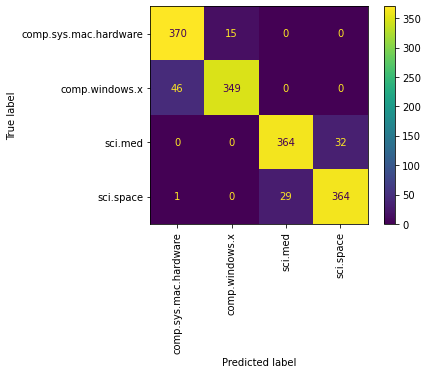

In [ ]:
metrics.plot_confusion_matrix(
    pipe,
    val_df['text_leaked_soft'],
    val_df['target'],
    xticks_rotation='vertical'
)

We see that comp and sci categories are almost never confused among each other, even though in general it would be hard to say whether this happens because the classes are easy to distinguish using normal features or if there is a soft leak, like in our case.

Data leakage is a subtle concept, in fact, quite a few Kaggle competitions were won by teams that were able to find data leakage and exploit it better than the other teams (the competition organizers made a mistake when preparing the dataset and hence there was a leak to be found). However, as you will work on more and more datasets, your data intuition will grow and the chance that you will make data leak errors will decrease!

## Machine Learning engineering, systems in the real world

Let's continue learning about more practical aspects of machine learning, complete the sub-courses (both the videos and check your understanding parts):

- https://developers.google.com/machine-learning/crash-course/production-ml-systems
- https://developers.google.com/machine-learning/crash-course/cancer-prediction

## Machine Learning problem framing

We already talked about how machine learning is a tool having its own limitations - not every problem needs machine learning or machine learning is just not the right tool. It is important to understand this deeply, as using a complex machine learning pipeline where a simpler solution suffices can lead to a lot of wasted resources.
To strengthen your understanding abou these topics, complete the course below:

- https://developers.google.com/machine-learning/problem-framing

## Testing and debugging

Finally, there will probably be not enough time to complete the course below, but testing and debugging machine learning is an important and complex topic, as you not only have to test machine learning models and pipelines as standard software (code correctness), but, as the performance of the machine learning model depends heavily on the training/testing data, you also have to test the data (data correctness).

Progress through the following course (including the checking your understanding and exercise parts):

- https://developers.google.com/machine-learning/testing-debugging

---

## Summary

In this notebook we learned about some practical topics in machine learning that help you understand the various risks that are inherent while developing and productionizing machine learning models. We also saw some practical examples of machine learning projects and improved our ability to understand whether machine learning is the right tool for a job. Using machine learning when it is not needed is another major risk while working in this area, but as your intuition about what works when will grow, you'll be able to avert it!